
# Random Forest con Python — Validación cruzada y evaluación end-to-end (postgrado)

Este notebook sigue **la estructura** del tutorial de *cienciadedatos.net* y agrega prácticas modernas de evaluación:

- **Búsqueda “arcaica”** por fuerza bruta con `for ...` + gráfica tipo “codo” (antes de CV/GS).
- **Validación cruzada (CV)** y **GridSearchCV** (sin fuga de información).
- **Importancia de variables**: por **pureza de nodos** (*impurity-based*) y por **permutación**.
- Guardar el **mejor modelo** y hacer una **predicción out-of-sample inventada**.

> Basado en: “Random Forest con Python”, Joaquín Amat Rodrigo (última actualización: Agosto 2025).


## Tres pilares del workflow: Cross-Validation, Hyperparameter Tuning e Importancia de Variables

En este notebook vamos a practicar **tres ideas centrales** para evaluar, ajustar e interpretar modelos de *Machine Learning* (en particular, Random Forest). Aunque aquí las aplicamos a regresión y clasificación, el razonamiento general es el mismo.

---

### 1) Cross-Validation (Validación cruzada)

La validación cruzada responde a una pregunta simple:

> **¿Qué tan bien generaliza mi modelo a datos nuevos, si mi dataset es limitado?**

En lugar de depender de **una sola partición** train/test (que puede ser “afortunada” o “desafortunada”), CV repite el proceso varias veces:

- se divide el dataset en **K pliegues** (*folds*),
- se entrena con **K−1 pliegues**,
- se evalúa con el pliegue restante,
- y se repite K veces, rotando el pliegue de evaluación.

Así obtenemos una estimación más **robusta** del desempeño: típicamente reportamos **media ± desviación estándar**.

**Diagrama (K-Fold CV, K=5):**

- **Fold 1**: [TEST] [TRAIN] [TRAIN] [TRAIN] [TRAIN]
- **Fold 2**: [TRAIN] [TEST] [TRAIN] [TRAIN] [TRAIN]
- **Fold 3**: [TRAIN] [TRAIN] [TEST] [TRAIN] [TRAIN]
- **Fold 4**: [TRAIN] [TRAIN] [TRAIN] [TEST] [TRAIN]
- **Fold 5**: [TRAIN] [TRAIN] [TRAIN] [TRAIN] [TEST]


✅ Ventajas:
- Reduce la dependencia de una sola partición.
- Permite comparar modelos de forma más justa.
- Da una idea de la **variabilidad** del desempeño.

⚠️ Nota práctica:
- El conjunto **test final** se reserva para el final (no se usa durante CV).

---

### 2) Hyperparameter Tuning (Ajuste de hiperparámetros)

Un Random Forest tiene “perillas” (hiperparámetros) que controlan **capacidad**, **regularización** y **estabilidad**. Ejemplos:

- `n_estimators`: número de árboles
- `max_features`: cuántas variables se consideran por split
- `max_depth`, `min_samples_leaf`: controlan complejidad y sobreajuste

La idea del tuning es:

> **Buscar la configuración que maximice la métrica objetivo (o la minimice, si es error).**

En el notebook mostramos dos estilos:

1) **Búsqueda manual (arcaica)** con `for` + gráfica tipo “codo” (ej. OOB RMSE / OOB accuracy)  
2) **Búsqueda formal** con `GridSearchCV` (o `RandomizedSearchCV`), usando CV.

**Diagrama del flujo correcto (sin fuga de información):**

**Datos totales** |+--> **TEST** (bloqueado, se usa 1 sola vez al final) |+--> **TRAIN** |+--> **(CV interna)** -> seleccionar hiperparámetros |+--> entrenar modelo final con mejores hiperparámetros | **Evaluación final en TEST**


✅ Ventajas:
- Evita elegir hiperparámetros “a ojo”.
- Reduce el riesgo de sobreajuste a una sola partición.
- Produce modelos más confiables para reportes/papers.

⚠️ Riesgo típico:
- “Mirar el test” durante tuning = **sobreestimar** desempeño (data leakage conceptual).

---

### 3) Feature Importances (Importancia de variables)

Una vez el modelo funciona, aparece otra pregunta clave:

> **¿Qué variables están aportando más a las predicciones?**

En Random Forest hay dos enfoques clásicos:

#### (A) Importancia por pureza (impurity-based)
Se basa en cuánto contribuye cada variable a reducir impureza (Gini/entropy) o error (regresión) a lo largo de los árboles.

✅ Pros: rápida y disponible directamente (`feature_importances_`)  
⚠️ Contras: puede favorecer variables con muchos posibles splits (o muchas categorías tras one-hot)

#### (B) Importancia por permutación (permutation importance)
Se permuta (baraja) una variable en el set de evaluación y se mide cuánto empeora la métrica:

- si empeora mucho → la variable era importante
- si casi no cambia → la variable aportaba poco

✅ Pros: más interpretativa y “model-agnostic”  
⚠️ Contras: más costosa computacionalmente

**Diagrama conceptual (permutación):**

- ``Score original (test): 0.86 ROC-AUC``
- ``Permutar variable X -> Score: 0.79 (bajó 0.07) => X importante``
- ``Permutar variable Y -> Score: 0.85 (bajó 0.01) => Y poco importante``


---

### Mensaje final (muy importante)
- **CV** te ayuda a estimar generalización con estabilidad.
- **Tuning** busca configuraciones que mejoran desempeño sin “hacer trampa”.
- **Importancias** ayudan a interpretar y comunicar qué variables dominan el modelo.

En conjunto, estas tres piezas convierten un entrenamiento “rápido” en un flujo **end-to-end** defendible académica y profesionalmente.

## Métricas que usaremos (intuición rápida)

### Regresión
- **MAE**: error promedio en unidades del objetivo. Fácil de interpretar.
- **RMSE**: penaliza más los errores grandes (sensible a outliers).
- **R²**: proporción de variabilidad explicada (útil como referencia, pero no siempre suficiente).

### Clasificación
- **Accuracy**: porcentaje correcto total (puede engañar si hay desbalance).
- **Balanced Accuracy**: promedio de aciertos por clase (mejor si hay desbalance).
- **F1**: balance entre precisión y recall (útil cuando importa el equilibrio FP/FN).
- **ROC-AUC**: calidad del ranking de probabilidades (independiente de umbral).
- **PR-AUC**: más informativa cuando la clase positiva es “rara” o hay desbalance.


---
## Ejemplo 1 — Regresión (Boston Housing)


### Librerías

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import joblib # esta librería se utiliza para guardar y cargar modelos entrenados
import sklearn
print("scikit-learn:", sklearn.__version__)


scikit-learn: 1.8.0


### Datos

## Dataset de regresión (Boston Housing) y planteamiento del problema

En esta primera parte trabajamos un problema de **regresión supervisada**, donde el objetivo es predecir una variable numérica continua a partir de un conjunto de predictores.

### ¿Qué contiene el dataset?
Usamos el dataset **Boston Housing** (en formato tabular), en el que cada fila representa una zona (o bloque) dentro del área metropolitana de Boston. El conjunto incluye variables explicativas asociadas a características socioeconómicas, urbanas y ambientales.  
La variable objetivo es:

- **`MEDV`**: valor mediano (en miles de dólares) de viviendas ocupadas por sus propietarios.

Algunos predictores típicos del dataset incluyen, por ejemplo:
- **`RM`**: número promedio de habitaciones por vivienda.
- **`LSTAT`**: porcentaje de población con “bajo estatus socioeconómico”.
- **`CRIM`**: tasa de criminalidad per cápita.
- **`NOX`**: concentración de óxidos de nitrógeno (contaminación).
- **`DIS`**: distancia a centros de empleo.
- **`TAX`**: tasa impositiva a la propiedad.

*(No es necesario memorizar cada variable; lo importante es entender que son “señales” que podrían explicar el valor de la vivienda.)*

### ¿Cuál es el problema de Machine Learning?
Queremos aprender una función predictiva:

$$
\hat{y} = f(\mathbf{x})
$$

donde:
- $\mathbf{x}$ es el vector de predictores (las columnas de entrada),
- $y$ es `MEDV`,
- $\hat{y}$ es el valor estimado por el modelo.

En términos prácticos: **dada la información de una zona, estimar el valor mediano de las viviendas**.

### ¿Cómo evaluaremos el desempeño?
En regresión, evaluamos la calidad de las predicciones comparando $\hat{y}$ vs $y$ con métricas como:
- **MAE** (Mean Absolute Error): error promedio en unidades del objetivo.
- **RMSE** (Root Mean Squared Error): penaliza más los errores grandes.
- **$R^2$**: proporción de varianza explicada por el modelo.

En el notebook, además, reservamos un conjunto **test** para evaluación final y usamos **validación cruzada** para estimar desempeño de forma más robusta.

In [2]:

# Dataset usado en el tutorial original
url_boston = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/"
    "master/data/Boston.csv"
)
datos = pd.read_csv(url_boston)
datos.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [3]:

datos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [47]:

X = datos.drop(columns="MEDV")
y = datos["MEDV"]

# Hold-out final (test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=321
)

# Sub-split interno (train/valid) para "búsqueda arcaica"
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=321
)

X_train.shape, X_test.shape, X_tr.shape, X_val.shape


((379, 12), (127, 12), (284, 12), (95, 12))

### Ajuste del modelo (baseline)

In [48]:

rf_base = RandomForestRegressor(
    n_estimators=400,
    random_state=321,
    n_jobs=-1
)

rf_base.fit(X_tr, y_tr)
pred_val = rf_base.predict(X_val)

{
    "RMSE_val": mean_squared_error(y_val, pred_val),
    "MAE_val": mean_absolute_error(y_val, pred_val),
    "R2_val": r2_score(y_val, pred_val),
}


{'RMSE_val': 9.580866634210526,
 'MAE_val': 2.246900000000001,
 'R2_val': 0.8939302194845808}

### Predicción y evaluación del modelo (test hold-out)

In [49]:

rf_base.fit(X_train, y_train)
pred_test = rf_base.predict(X_test)

{
    "RMSE_test": mean_squared_error(y_test, pred_test),
    "MAE_test": mean_absolute_error(y_test, pred_test),
    "R2_test": r2_score(y_test, pred_test),
}


{'RMSE_test': 13.627423228838571,
 'MAE_test': 2.4816633858267703,
 'R2_test': 0.8458858267122584}

## OOB (Out-of-Bag): una validación “interna” de Random Forest

Random Forest entrena cada árbol con una muestra *bootstrap* (con reemplazo).  
Eso significa que, para cada árbol, queda un subconjunto de observaciones **fuera** del muestreo: las *out-of-bag* (OOB).

La idea OOB es:
- predecir cada observación usando **solo** los árboles donde esa observación fue OOB,
- y con eso estimar un error/score “interno” sin crear un validation set explícito.

### ¿Para qué lo usamos aquí?
Lo usamos como herramienta didáctica para la **búsqueda manual** (bucle `for` + gráfica tipo codo): es rápido y ayuda a visualizar tendencias (p.ej., al aumentar `n_estimators`).

### Importante
OOB es útil, pero **no reemplaza** una evaluación formal con **Cross-Validation** cuando quieres comparar modelos o ajustar hiperparámetros de forma robusta.


### Optimización de hiperparámetros (modo “arcaico” con `for` + gráfica tipo codo)

Antes de usar **GridSearchCV** o **CV**, era común hacer:

1) Dividir en **train/valid**  
2) Probar a mano un hiperparámetro con un bucle  
3) Elegir el mejor según el score en validación

Aquí lo haremos de forma didáctica con **out-of-bag (OOB)**, que es propio de Random Forest.


#### Número de árboles (n_estimators) — OOB RMSE

In [50]:

def oob_rmse_reg(model: RandomForestRegressor, y_true: np.ndarray) -> float:
    oob_pred = model.oob_prediction_
    mask = ~np.isnan(oob_pred)
    return mean_squared_error(y_true[mask], oob_pred[mask])

n_estimators_grid = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
oob_rmse_list = []

for n in n_estimators_grid:
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=123,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True
    )
    rf.fit(X_train, y_train)
    oob_rmse_list.append(oob_rmse_reg(rf, y_train.to_numpy()))

best_n = n_estimators_grid[int(np.argmin(oob_rmse_list))]
best_n, oob_rmse_list


(500,
 [11.275046424050354,
  11.308486454849788,
  11.331550941120387,
  11.346434622079611,
  11.075693721874696,
  11.0222286536531,
  11.06244974711377,
  11.065977956736766,
  11.046726089984125,
  11.053274499788813,
  11.0396905319986,
  11.039457715633088,
  11.046007012065711])

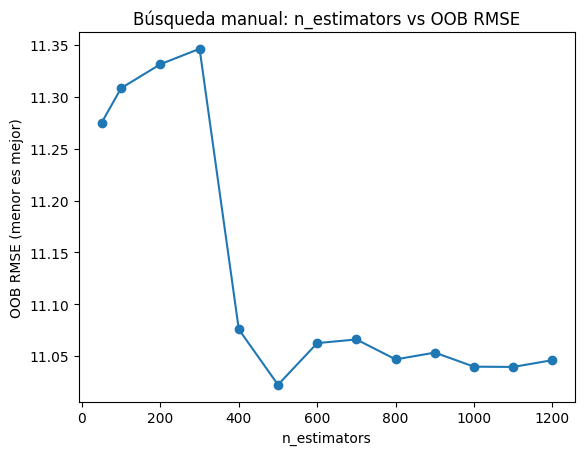

In [51]:

plt.figure()
plt.plot(n_estimators_grid, oob_rmse_list, marker="o")
plt.xlabel("n_estimators")
plt.ylabel("OOB RMSE (menor es mejor)")
plt.title("Búsqueda manual: n_estimators vs OOB RMSE")
plt.show()


#### Max features — OOB RMSE

In [52]:

max_features_grid = ["sqrt", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
oob_rmse_mf = []

for mf in max_features_grid:
    rf = RandomForestRegressor(
        n_estimators=best_n,
        max_features=mf,
        random_state=123,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True
    )
    rf.fit(X_train, y_train)
    oob_rmse_mf.append(oob_rmse_reg(rf, y_train.to_numpy()))

best_mf = max_features_grid[int(np.argmin(oob_rmse_mf))]
best_mf, oob_rmse_mf


(0.4,
 [10.168499405635059,
  14.347659438092231,
  11.055780655637472,
  10.168499405635059,
  9.859806818547263,
  10.197836539497867,
  10.04172948862809,
  9.874576702640482,
  10.56881443126559,
  10.63024465940897,
  11.0222286536531])

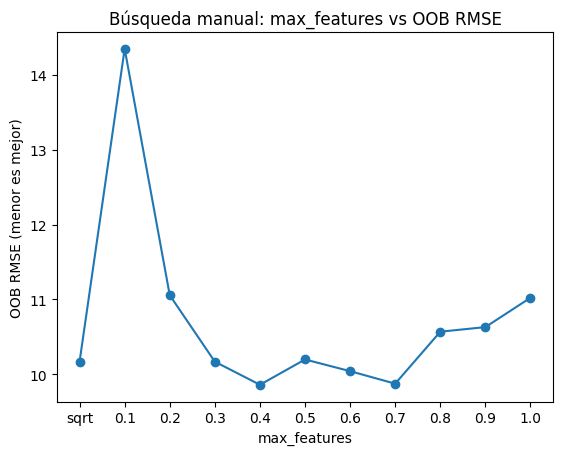

In [53]:

plt.figure()
plt.plot([str(x) for x in max_features_grid], oob_rmse_mf, marker="o")
plt.xlabel("max_features")
plt.ylabel("OOB RMSE (menor es mejor)")
plt.title("Búsqueda manual: max_features vs OOB RMSE")
plt.show()



### Grid search (validación cruzada)

Ahora sí: optimización “formal” con CV dentro del entrenamiento.  
El test sigue **intacto**.


In [55]:

cv = KFold(n_splits=5, shuffle=True, random_state=321)

param_grid_reg = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_features": ["sqrt", 0.4, 0.7],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [None, 6, 12],
}

gs_reg = GridSearchCV(
    estimator=RandomForestRegressor(random_state=321, n_jobs=-1),
    param_grid=param_grid_reg,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    refit=True
)

gs_reg.fit(X_train, y_train)
gs_reg.best_params_, -gs_reg.best_score_


({'max_depth': None,
  'max_features': 0.4,
  'min_samples_leaf': 1,
  'n_estimators': 800},
 np.float64(3.1215422207508903))

### Predicción y evaluación del mejor modelo (test final)

In [56]:

best_reg = gs_reg.best_estimator_
pred_test_best = best_reg.predict(X_test)

{
    "RMSE_test": mean_squared_error(y_test, pred_test_best),
    "MAE_test": mean_absolute_error(y_test, pred_test_best),
    "R2_test": r2_score(y_test, pred_test_best),
}


{'RMSE_test': 13.380381575787448,
 'MAE_test': 2.3768208661417325,
 'R2_test': 0.8486796505693646}


### Importancia de predictores
1) **Pureza de nodos** (rápida, pero puede sesgarse)  
2) **Permutación** (más informativa, más costosa)


#### Pureza de nodos (feature_importances_)

In [13]:

imp = pd.Series(best_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp.head(15)


RM         0.388936
LSTAT      0.318530
DIS        0.059271
NOX        0.057869
CRIM       0.046235
PTRATIO    0.042344
INDUS      0.037617
AGE        0.020197
TAX        0.019943
RAD        0.005477
ZN         0.002599
CHAS       0.000982
dtype: float64

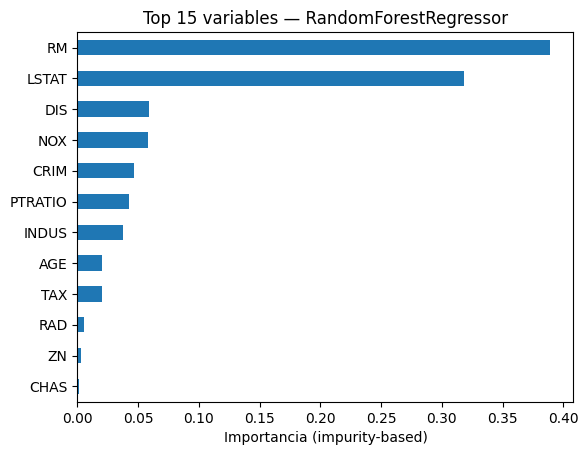

In [14]:

plt.figure()
imp.head(15).sort_values().plot(kind="barh")
plt.xlabel("Importancia (impurity-based)")
plt.title("Top 15 variables — RandomForestRegressor")
plt.show()


#### Permutación (Permutation Importance)

In [15]:

perm = permutation_importance(
    best_reg, X_test, y_test,
    n_repeats=20,
    random_state=123,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_imp.head(15)


LSTAT      3.728492
RM         2.830690
DIS        0.736448
NOX        0.318199
CRIM       0.285011
PTRATIO    0.235358
TAX        0.141194
INDUS      0.112325
RAD        0.041449
AGE        0.018894
CHAS       0.005297
ZN         0.001077
dtype: float64

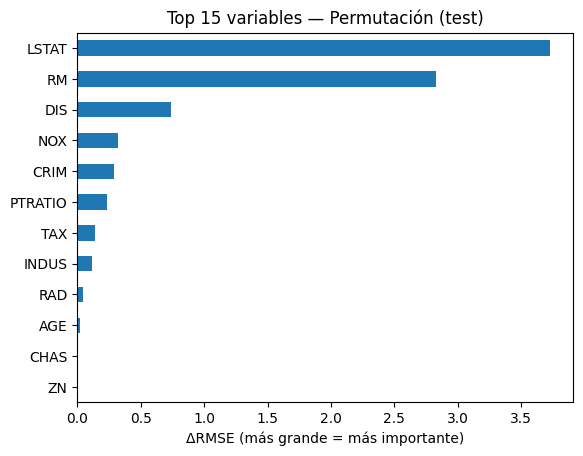

In [16]:

plt.figure()
perm_imp.head(15).sort_values().plot(kind="barh")
plt.xlabel("ΔRMSE (más grande = más importante)")
plt.title("Top 15 variables — Permutación (test)")
plt.show()



### Guardar el mejor modelo + predicción out-of-sample inventada


## Guardado del modelo con `joblib` (¿qué es y por qué importa?)

Al finalizar el entrenamiento, guardamos el **mejor modelo** en un archivo usando `joblib` (por ejemplo: `rf_boston_best.joblib` o `rf_carseats_best_pipeline.joblib`).

### ¿Qué contiene el archivo `.joblib`?
Depende del caso, pero típicamente incluye **un objeto de scikit-learn serializado**, por ejemplo:

- En **regresión**: un `RandomForestRegressor` ya entrenado  
  (estructura de árboles, parámetros aprendidos y configuración).
- En **clasificación**: el **pipeline completo**, por ejemplo:
  - `ColumnTransformer` (con el `OneHotEncoder` ya “fiteado”: categorías aprendidas),
  - `RandomForestClassifier` entrenado.

Es decir, el archivo guarda **todo lo necesario para predecir** en el futuro **sin reentrenar**.

### ¿Por qué es importante?
- **Reproducibilidad:** puedes congelar exactamente el modelo usado en un experimento o reporte.
- **Despliegue / producción:** permite cargar el modelo en otro script, API o dashboard y predecir en tiempo real.
- **Portabilidad:** lo puedes mover a otra máquina/entorno (mientras tengas versiones compatibles).
- **Evita repetir cómputo:** entrenar puede ser costoso; cargar un `.joblib` es rápido.

### Idea clave
Guardar el **pipeline** (no solo el modelo) es especialmente valioso cuando hay preprocesado (p.ej., one-hot),
porque garantiza que los datos nuevos se transformen **exactamente igual** que durante el entrenamiento.

In [17]:

# Guardar
path_reg = "rf_boston_best.joblib"
joblib.dump(best_reg, path_reg)

# Cargar
best_reg_loaded = joblib.load(path_reg)

# Observación inventada (tomamos la mediana y la "movemos" un poco)
x_new = X_train.median().copy()
x_new["RM"] = x_new["RM"] + 0.5          # más habitaciones promedio
x_new["LSTAT"] = max(0, x_new["LSTAT"] - 2)  # menor % estatus bajo

X_new = pd.DataFrame([x_new], columns=X_train.columns)

pred_new = best_reg_loaded.predict(X_new)[0]
pred_new


np.float64(25.56625)


---
## **Ejemplo 2 — Clasificación (Carseats / ISLR)**


### Librerías

In [18]:

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


### Datos

## Dataset de clasificación (Carseats / ISLR) y planteamiento del problema

En esta segunda parte trabajamos un problema de **clasificación supervisada**, donde el objetivo es predecir una **clase** (0/1) a partir de un conjunto de variables explicativas.

### ¿Qué contiene el dataset?
Usamos el dataset **Carseats** (del libro ISLR), que describe el desempeño de ventas de sillas infantiles en **400 tiendas**.  
Cada fila corresponde a una tienda y las columnas incluyen variables de mercado y características del contexto comercial, por ejemplo:

- **`Price`**: precio de venta en la tienda  
- **`CompPrice`**: precio de la competencia  
- **`Advertising`**: inversión en publicidad (unidades monetarias)  
- **`Income`**, **`Population`**, **`Age`**, **`Education`**: atributos del mercado local  
- **`ShelveLoc`** (categórica): calidad de ubicación en estantería (*Bad/Medium/Good*)  
- **`Urban`**, **`US`** (categóricas): indicadores tipo Sí/No  

En el dataset original también existe `Sales` (ventas, continua). Para convertirlo en clasificación, definimos una variable binaria:

$$
\texttt{HighSales} = \mathbb{1}(\texttt{Sales} > 8)
$$

Es decir:
- `HighSales = 1` si las ventas son “altas”
- `HighSales = 0` si no

### ¿Cuál es el problema de Machine Learning?
Queremos aprender una función que estime la probabilidad de ventas altas:

$$
\hat{p} = P(\texttt{HighSales}=1 \mid \mathbf{x})
$$

y luego asignar una clase (por ejemplo con umbral 0.5):

$$
\hat{y} =
\begin{cases}
1, & \hat{p} \ge 0.5 \\
0, & \hat{p} < 0.5
\end{cases}
$$

En términos prácticos: **dadas las condiciones de una tienda, predecir si tendrá ventas altas o no.**

### Nota importante (variables categóricas)
Como existen variables categóricas (`ShelveLoc`, `Urban`, `US`), usamos un **Pipeline** con `OneHotEncoder` para convertirlas a variables numéricas **sin fuga de información** durante validación cruzada.

### ¿Cómo evaluaremos el desempeño?
En clasificación evaluamos con métricas como:
- **Accuracy** (exactitud)
- **Balanced Accuracy** (útil si hay desbalance)
- **F1-score** (balance entre precisión y recall)
- **ROC-AUC / PR-AUC** (evaluación basada en probabilidades)

In [19]:

# Carseats (ISLR) desde Rdatasets
url_carseats = "https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Carseats.csv"
car = pd.read_csv(url_carseats)

# Algunas fuentes añaden una columna índice (p.ej. 'Unnamed: 0' o 'rownames').
for col in ["Unnamed: 0", "rownames"]:
    if col in car.columns:
        car = car.drop(columns=[col])

car.head()


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [20]:

car.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [21]:

# Objetivo binario: HighSales (1 si Sales > 8)
car["HighSales"] = (car["Sales"] > 8).astype(int)
car = car.drop(columns=["Sales"])

X = car.drop(columns=["HighSales"])
y = car["HighSales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=123, stratify=y_train
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(HighSales
 0    0.59
 1    0.41
 Name: proportion, dtype: float64,
 HighSales
 0    0.59
 1    0.41
 Name: proportion, dtype: float64)

## Cuidado con el *data leakage* (fuga de información) y por qué usamos `Pipeline`

Uno de los errores más comunes en evaluación de modelos es el **data leakage**: usar información del conjunto de evaluación (valid/test) durante el entrenamiento *sin querer*.  
Esto suele pasar cuando hacemos preprocesado *fuera* del flujo de entrenamiento, por ejemplo:

- ajustar un **OneHotEncoder** con todos los datos y luego evaluar,
- imputar/estandarizar usando estadísticas calculadas con todo el dataset,
- seleccionar variables mirando el test.

### Regla de oro
Todo lo que “aprende” de los datos (encoders, imputación, escalado, selección de variables) debe estar dentro de un:

- `Pipeline` (y si hay columnas mixtas, dentro de un `ColumnTransformer`)

Así, durante validación cruzada, el preprocesado se ajusta **solo con el fold de entrenamiento** y se aplica al fold de validación/test sin contaminarlo.

### Ajuste del modelo (Pipeline + baseline)

In [22]:

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

preprocess = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

rf_clf_base = RandomForestClassifier(
    n_estimators=600,
    random_state=123,
    n_jobs=-1
)

pipe_base = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf_clf_base)
])

pipe_base.fit(X_tr, y_tr)
pred_val = pipe_base.predict(X_val)

{
    "Accuracy_val": accuracy_score(y_val, pred_val),
    "BalancedAcc_val": balanced_accuracy_score(y_val, pred_val),
    "F1_val": f1_score(y_val, pred_val),
}


{'Accuracy_val': 0.8533333333333334,
 'BalancedAcc_val': 0.8368768328445748,
 'F1_val': 0.8070175438596491}

### Predicción y evaluación (test hold-out)

In [23]:

pipe_base.fit(X_train, y_train)
pred_test = pipe_base.predict(X_test)

{
    "Accuracy_test": accuracy_score(y_test, pred_test),
    "BalancedAcc_test": balanced_accuracy_score(y_test, pred_test),
    "F1_test": f1_score(y_test, pred_test),
}


{'Accuracy_test': 0.8,
 'BalancedAcc_test': 0.7821413807358413,
 'F1_test': 0.7368421052631579}

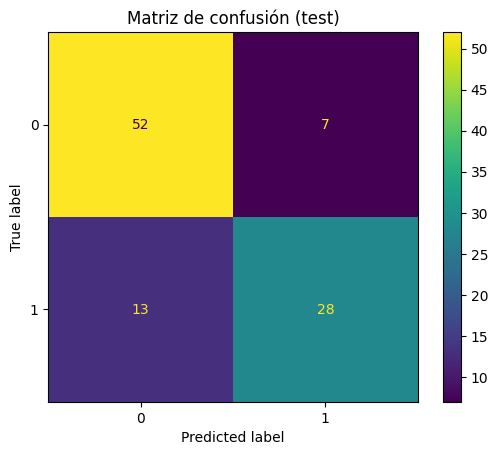

In [24]:

cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Matriz de confusión (test)")
plt.show()


## Train / Validation / Test: quién hace qué (y por qué)

En este notebook usamos dos formas de “validar” hiperparámetros:

1) **Enfoque clásico (train/validation):**  
   se separa un conjunto de *validación* y se prueban hiperparámetros con un bucle `for`.  
   Es útil para entender la idea, pero depende de una sola partición.

2) **Enfoque moderno (Cross-Validation):**  
   reemplaza una única validación por K validaciones (K folds), estimando mejor la generalización.

### El conjunto *test* es sagrado
El **test** se reserva desde el inicio y se usa **una sola vez** al final, para reportar el desempeño final del “mejor modelo” ya escogido.


### Ajuste y optimización de hiperparámetros (modo “arcaico” con `for` + “codo”)

Aquí usamos **out-of-bag (OOB accuracy)** como criterio rápido, sin CV.


#### Número de árboles (n_estimators) — OOB accuracy

In [25]:

n_estimators_grid = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
oob_acc = []

for n in n_estimators_grid:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=123,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True
    )
    pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])
    pipe.fit(X_train, y_train)
    oob_acc.append(pipe.named_steps["model"].oob_score_)

best_n = n_estimators_grid[int(np.argmax(oob_acc))]
best_n, oob_acc


(300,
 [0.81,
  0.8266666666666667,
  0.8333333333333334,
  0.8433333333333334,
  0.84,
  0.8366666666666667,
  0.8333333333333334,
  0.8333333333333334,
  0.8366666666666667,
  0.8366666666666667,
  0.8333333333333334,
  0.83,
  0.83])

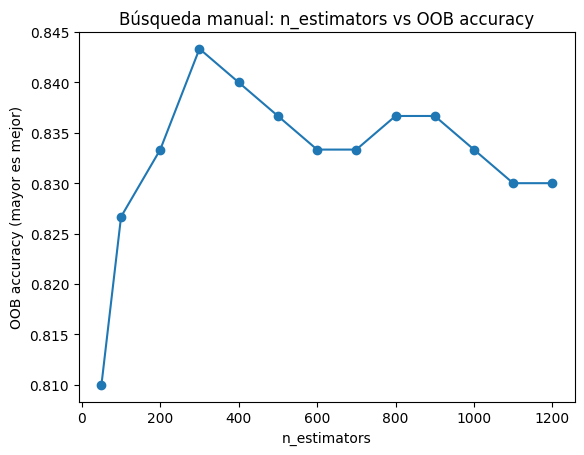

In [26]:

plt.figure()
plt.plot(n_estimators_grid, oob_acc, marker="o")
plt.xlabel("n_estimators")
plt.ylabel("OOB accuracy (mayor es mejor)")
plt.title("Búsqueda manual: n_estimators vs OOB accuracy")
plt.show()


#### Max features — OOB accuracy

In [27]:

max_features_grid = ["sqrt", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
oob_acc_mf = []

for mf in max_features_grid:
    rf = RandomForestClassifier(
        n_estimators=best_n,
        max_features=mf,
        random_state=123,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True
    )
    pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])
    pipe.fit(X_train, y_train)
    oob_acc_mf.append(pipe.named_steps["model"].oob_score_)

best_mf = max_features_grid[int(np.argmax(oob_acc_mf))]
best_mf, oob_acc_mf


('sqrt',
 [0.8433333333333334,
  0.8,
  0.8266666666666667,
  0.84,
  0.83,
  0.82,
  0.8266666666666667,
  0.8233333333333334,
  0.82,
  0.8233333333333334,
  0.8166666666666667])

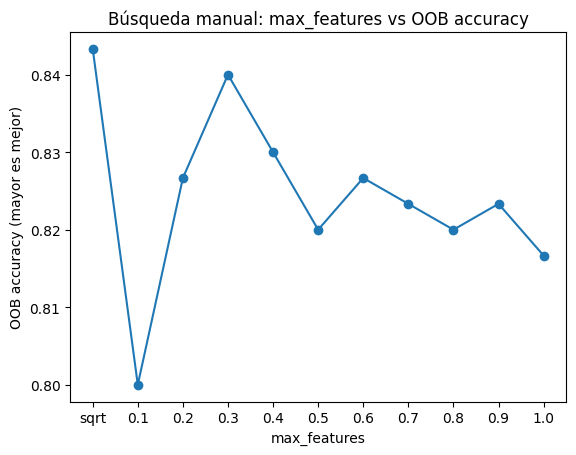

In [28]:

plt.figure()
plt.plot([str(x) for x in max_features_grid], oob_acc_mf, marker="o")
plt.xlabel("max_features")
plt.ylabel("OOB accuracy (mayor es mejor)")
plt.title("Búsqueda manual: max_features vs OOB accuracy")
plt.show()



### Grid Search (validación cruzada)


In [29]:

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

param_grid_clf = {
    "model__n_estimators": [200, 600, 900],
    "model__max_features": ["sqrt", 0.5],
    "model__min_samples_leaf": [1, 5],
    "model__max_depth": [None, 10],
}

gs_clf = GridSearchCV(
    estimator=pipe_base,
    param_grid=param_grid_clf,
    scoring="roc_auc",
    cv=cv_clf,
    n_jobs=-1,
    refit=True
)

gs_clf.fit(X_train, y_train)
gs_clf.best_params_, gs_clf.best_score_


({'model__max_depth': None,
  'model__max_features': 0.5,
  'model__min_samples_leaf': 1,
  'model__n_estimators': 600},
 np.float64(0.9220625661375662))

### Predicción y evaluación del mejor modelo (test final)

In [30]:

best_pipe = gs_clf.best_estimator_
pred_best = best_pipe.predict(X_test)
proba_best = best_pipe.predict_proba(X_test)[:, 1]

{
    "Accuracy_test": accuracy_score(y_test, pred_best),
    "BalancedAcc_test": balanced_accuracy_score(y_test, pred_best),
    "F1_test": f1_score(y_test, pred_best),
}


{'Accuracy_test': 0.78,
 'BalancedAcc_test': 0.7614716825134353,
 'F1_test': 0.7105263157894737}

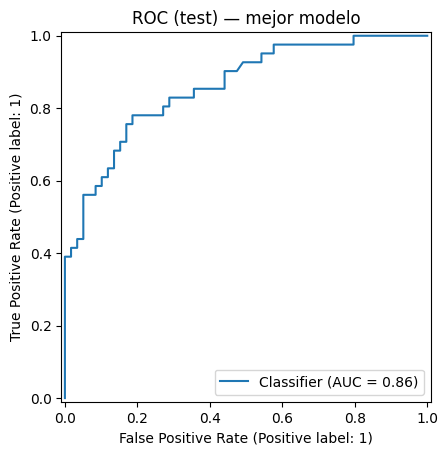

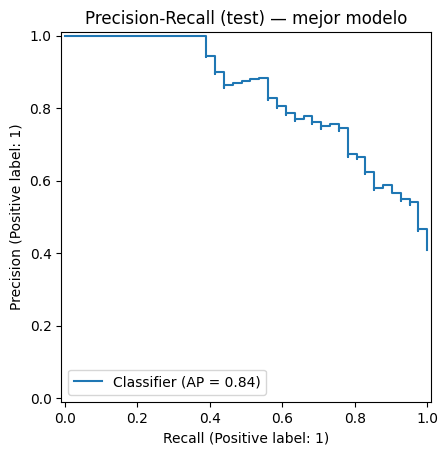

In [31]:

RocCurveDisplay.from_predictions(y_test, proba_best)
plt.title("ROC (test) — mejor modelo")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_best)
plt.title("Precision-Recall (test) — mejor modelo")
plt.show()



### Importancia de predictores (clasificación)

- **Pureza de nodos** sobre features transformadas (one-hot + numéricas).  
- **Agregación** por variable original (sumando dummies).  
- **Permutación** por variable original (sobre X_test sin transformar).


In [32]:

def get_feature_names(ct: ColumnTransformer) -> np.ndarray:
    return np.array(ct.get_feature_names_out(), dtype=str)

feat_names = get_feature_names(best_pipe.named_steps["prep"])
model_clf = best_pipe.named_steps["model"]

imp = pd.Series(model_clf.feature_importances_, index=feat_names).sort_values(ascending=False)
imp.head(20)


remainder__Price            0.247891
remainder__Advertising      0.125773
remainder__Age              0.107486
onehot__ShelveLoc_Good      0.102935
remainder__Income           0.099678
remainder__CompPrice        0.096540
remainder__Population       0.060678
onehot__ShelveLoc_Bad       0.059469
remainder__Education        0.040728
onehot__ShelveLoc_Medium    0.023763
onehot__US_No               0.012089
onehot__US_Yes              0.010916
onehot__Urban_Yes           0.006175
onehot__Urban_No            0.005877
dtype: float64

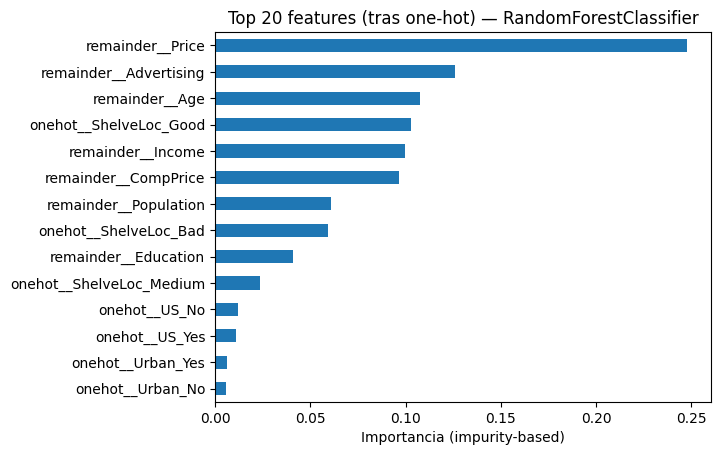

In [33]:

plt.figure()
imp.head(20).sort_values().plot(kind="barh")
plt.xlabel("Importancia (impurity-based)")
plt.title("Top 20 features (tras one-hot) — RandomForestClassifier")
plt.show()


In [34]:

# Agregación por variable original
def base_var_name(feature_name: str) -> str:
    # quitar prefijos tipo "onehot__" o "remainder__"
    if "__" in feature_name:
        feature_name = feature_name.split("__", 1)[1]
    # dummy: "ShelveLoc_Good" -> base "ShelveLoc"
    if "_" in feature_name and feature_name.split("_", 1)[0] in cat_cols:
        return feature_name.split("_", 1)[0]
    return feature_name

imp_by_var = imp.groupby([base_var_name(k) for k in imp.index]).sum().sort_values(ascending=False)
imp_by_var.head(15)


Price          0.247891
ShelveLoc      0.186167
Advertising    0.125773
Age            0.107486
Income         0.099678
CompPrice      0.096540
Population     0.060678
Education      0.040728
US             0.023005
Urban          0.012052
dtype: float64

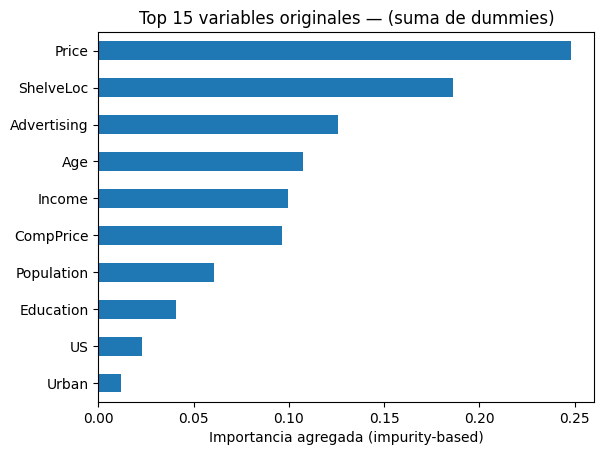

In [35]:

plt.figure()
imp_by_var.head(15).sort_values().plot(kind="barh")
plt.xlabel("Importancia agregada (impurity-based)")
plt.title("Top 15 variables originales — (suma de dummies)")
plt.show()


In [36]:

# Permutation importance por variable original (sobre el pipeline completo)
perm = permutation_importance(
    best_pipe, X_test, y_test,
    n_repeats=15,
    random_state=123,
    scoring="roc_auc",
    n_jobs=-1
)

perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_imp


ShelveLoc      0.187943
Price          0.116784
CompPrice      0.071324
Advertising    0.035635
Age            0.027739
US             0.008764
Urban          0.001736
Income         0.000331
Education     -0.004506
Population    -0.014827
dtype: float64

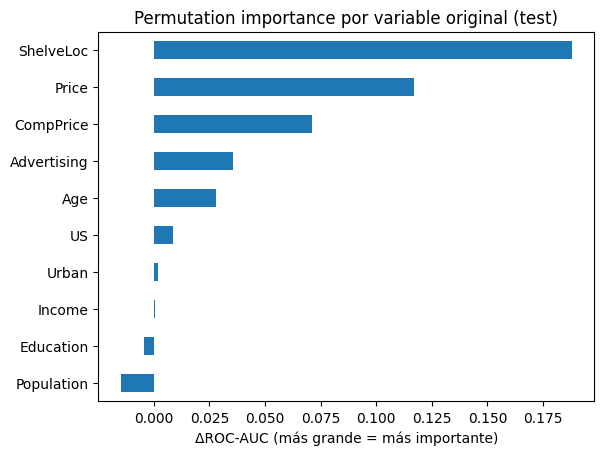

In [37]:

plt.figure()
perm_imp.sort_values().plot(kind="barh")
plt.xlabel("ΔROC-AUC (más grande = más importante)")
plt.title("Permutation importance por variable original (test)")
plt.show()


### Guardar el mejor modelo + predicción out-of-sample inventada

In [38]:

path_clf = "rf_carseats_best_pipeline.joblib"
joblib.dump(best_pipe, path_clf)

best_pipe_loaded = joblib.load(path_clf)

# Observación inventada (una tienda hipotética)
X_new = pd.DataFrame([{
    "CompPrice": 130,
    "Income": 65,
    "Advertising": 10,
    "Population": 300,
    "Price": 110,
    "Age": 45,
    "Education": 14,
    "ShelveLoc": "Good",
    "Urban": "Yes",
    "US": "Yes"
}])

proba = best_pipe_loaded.predict_proba(X_new)[0, 1]
pred = best_pipe_loaded.predict(X_new)[0]

{"pred_class": int(pred), "proba_HighSales": float(proba)}


{'pred_class': 1, 'proba_HighSales': 0.9083333333333333}


---
## Mini-checklist

- Separar **test** una sola vez y NO tocarlo hasta el final.  
- Preprocesado dentro de **Pipeline** (evita data leakage).  
- Tuning: **GridSearchCV** con **CV** (o técnicas más avanzadas).  
- Reportar: CV (media ± std) + test final.  
- Interpretabilidad: importancia por **pureza** y por **permutación**.  
- Guardar el mejor modelo y probar con casos **out-of-sample**.
